In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**READING THE DATA FRAME**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Mestrado/Mestrado_CIn_2023/Topicos em IC 2/Atividade 4 - Feature importance/Data/healthcare-dataset-stroke-data.csv')

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Contabilizando a base

Número de exemplos: 5110 | Número de features: 11


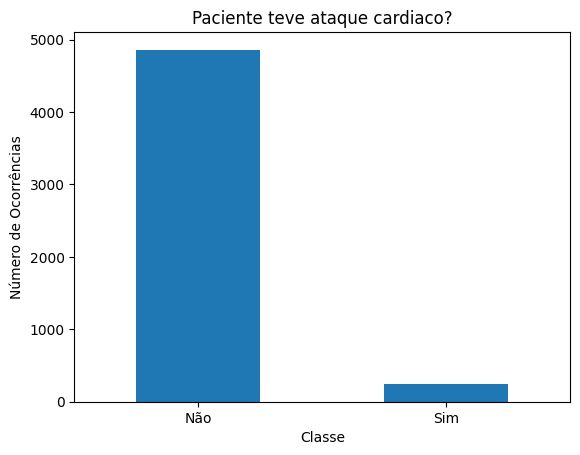

In [4]:
print(f"Número de exemplos: {df.shape[0]} | Número de features: {df.shape[1] - 1}")

# Contando o número de ocorrências de cada classe
contagem_classes = df['stroke'].value_counts()

# Plotando o resultado
contagem_classes.plot(kind='bar')
plt.title('Paciente teve ataque cardiaco?')
plt.xlabel('Classe')
plt.ylabel('Número de Ocorrências')
plt.xticks([0, 1], ['Não', 'Sim'], rotation=0) # Ajustando os rótulos do eixo x
plt.show()


## Pré processamento

Antes de separar a base removeremos a coluna de 'id' para evitar vies e também faremos a aplicação do one hot encoding em todas as colunas categoricas.

O one hot encoding garante que as colunas com items categoricos (string) serão utilizaveis para algoritmos como randomForest.

Além disso, a coluna Smoking possui valores "Unknown". Todos os casos serão removidos. Apesar de muitos casos, não quero incluir uma coluna com tantos valores faltantes e que possui potencialmente uma informação primordial para a decisão do modelo.

Todas as linhas com NaN serão removidas

In [5]:
df = df.drop('id',axis=1)

In [6]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_column(df, column_name):
    encoder = OneHotEncoder(sparse_output=False)
    df_nonan = df.dropna(subset=[column_name])
    df_encoded = encoder.fit_transform(df_nonan[[column_name]])
    categories = encoder.categories_[0]
    print(f"Coluna: {column_name} -> {categories}")
    df_encoded = pd.DataFrame(df_encoded, columns=categories, index=df_nonan.index)
    return pd.concat([df.drop(column_name, axis=1), df_encoded], axis=1)

processed_df = df.copy()

processed_df = processed_df[processed_df['smoking_status'] != 'Unknown']
processed_df.dropna(inplace=True)

processed_df['ever_married'] = processed_df['ever_married'].map({'Yes': 1, 'No': 0})
processed_df.reset_index(drop=True, inplace=True)

# 3. One-Hot Encoding
print("Aplicando o one hot encoding")
categories = ['gender', 'work_type', 'Residence_type', 'smoking_status']
for category in categories:
    processed_df = one_hot_encode_column(processed_df, category)
    # É crucial resetar o índice após cada aplicação para manter a integridade
    processed_df.reset_index(drop=True, inplace=True)

processed_df.head()


Aplicando o one hot encoding
Coluna: gender -> ['Female' 'Male' 'Other']
Coluna: work_type -> ['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
Coluna: Residence_type -> ['Rural' 'Urban']
Coluna: smoking_status -> ['formerly smoked' 'never smoked' 'smokes']


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,formerly smoked,never smoked,smokes
0,67.0,0,1,1,228.69,36.6,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,80.0,0,1,1,105.92,32.5,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,49.0,0,0,1,171.23,34.4,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,79.0,1,0,1,174.12,24.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,81.0,0,0,1,186.21,29.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Contagem de classes após pré processamento

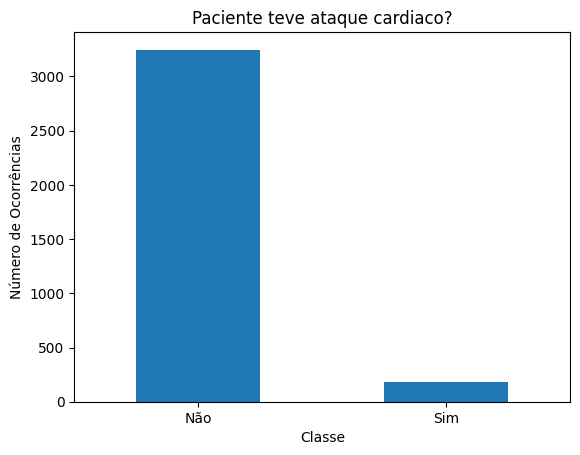

In [8]:
# Contando o número de ocorrências de cada classe
contagem_classes = processed_df['stroke'].value_counts()

# Plotando o resultado
contagem_classes.plot(kind='bar')
plt.title('Paciente teve ataque cardiaco?')
plt.xlabel('Classe')
plt.ylabel('Número de Ocorrências')
plt.xticks([0, 1], ['Não', 'Sim'], rotation=0) # Ajustando os rótulos do eixo x
plt.show()

Utilizaremos o parâmetro stratify para garantir que a base de teste possui a mesma proporção da base de treino, visto que a proporção.

In [9]:
from sklearn.model_selection import train_test_split

X = processed_df.drop(columns=['stroke'])
Y = processed_df['stroke']

# Separando os dados em treinamento(75%) e teste(25%)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,stratify=Y)


Verificando se as proporções dos conjuntos de treino e teste estão equivalentes. Como as classes são divididas em 0 e 1 podemos usar a soma como uma representação da quantidade de positivos em relção ao total (comprimento do array).

In [10]:
Y_train.sum()/len(Y_train),Y_test.sum()/len(Y_test)

(0.05254963020630596, 0.052508751458576426)

**--- LEARNING THE RF CLASSIFIER**

In [18]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced').fit(X_train, Y_train)

Verificando a acurácia do classificador

In [17]:
Y_test.sum()

45

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Definindo o espaço de parâmetros para o GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample']  # Incluindo pesos das classes
}

# Criando o classificador Random Forest
rf = RandomForestClassifier()

# Usando make_scorer para criar um score baseado no f1_score
f1_scorer = make_scorer(f1_score, average='macro')  # 'macro' para considerar o desbalanceamento

# Criando o GridSearchCV com o score f1
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=f1_scorer, cv=5)

# Treinando o modelo usando o GridSearchCV
grid_search.fit(X_train, Y_train)

# Melhores parâmetros encontrados
print(grid_search.best_params_)

# Melhor score F1 alcançado
print(f"Melhor f1 score encontrado: {grid_search.best_score_}")

# Usar o melhor modelo encontrado
best_rf = grid_search.best_estimator_

{'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}
Melhor f1 score encontrado: 0.5801111225599488


### **PERMUTATION FEATURE IMPORTANCE**

In [28]:
forest_importances

age                  0.012246
hypertension         0.002079
heart_disease       -0.002567
ever_married        -0.000365
avg_glucose_level    0.000118
bmi                  0.000563
Female              -0.002209
Male                -0.002420
Other                0.000000
Govt_job            -0.003386
Never_worked         0.000000
Private              0.002008
Self-employed        0.002008
children            -0.000325
Rural                0.000706
Urban                0.003470
formerly smoked      0.003253
never smoked        -0.000346
smokes               0.001006
dtype: float64

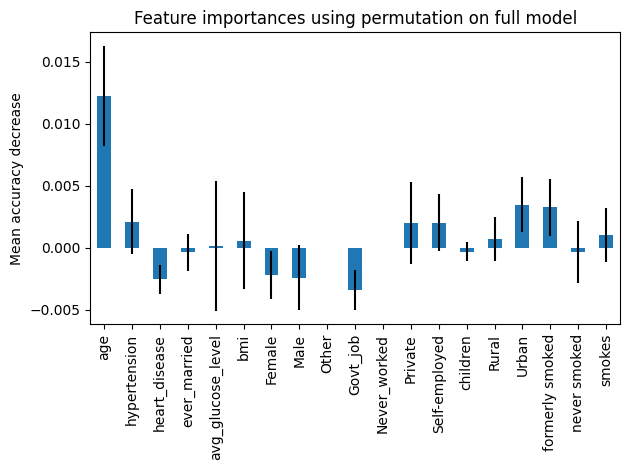

In [27]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
scoring = make_scorer(f1_score, average='weighted')

result = permutation_importance(best_rf, X_test, Y_test,n_repeats=30, random_state=0,scoring=scoring)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean f1 decrease")
fig.tight_layout()
plt.show()

Verificando o feature importance por classe

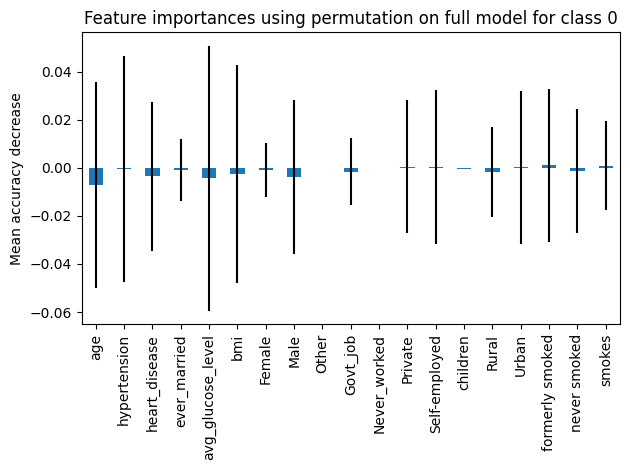

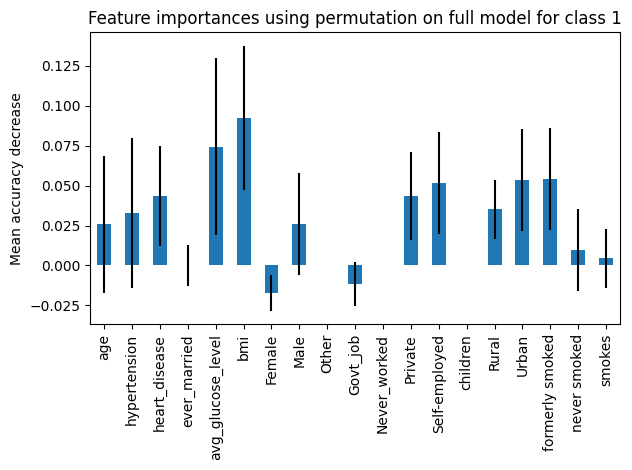

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Classes únicas no conjunto de teste
unique_classes = np.unique(Y_test)

# Dicionário para armazenar as importâncias das features por classe
importances_by_class = {}

for class_label in unique_classes:
    # Selecionar amostras da classe atual
    X_test_class = X_test[Y_test == class_label]
    Y_test_class = Y_test[Y_test == class_label]

    # Calcular a importância das features para a classe atual
    result = permutation_importance(best_rf, X_test_class, Y_test_class, n_repeats=30, random_state=0,scoring=scoring)

    # Armazenar o resultado no dicionário
    importances_by_class[class_label] = result.importances_mean

for class_label in unique_classes:
    forest_importances = pd.Series(importances_by_class[class_label], index=X_test.columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(f"Feature importances using permutation on full model for class {class_label}")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

Como pode ser visto, os resultados para a classe positiva são, em sua maioria valores positivos, indicativos de uma 'melhora' no modelo com a permutação da métrica em questão. Isso pode ter relação com 2 coisas: overfitting do modelo ou um baixo numero de instâncias de teste positivas para testar o modelo.

Já para os resultados negativos é possível observar que os features mais importantes são:
- idade
- Problemas de coração
- Indice de massa corporal (bmi)
- nível médio de glicose no sangue